In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read all data into a list of dataframes
import os 
path = r"C:\Users\xj537\Documents\GoodGoodStudy\Graduate\Active Portfolio Management\Assignments\Project\Data"
files= os.listdir(path)
dfs = []
for file in files:
    df = pd.read_csv(path+'\\'+file, sep = '|', index_col = 'PERMNO')
    dfs.append(df)

Problem 1 - Multifactor Model

In [3]:
# Do one-hot coding for INDUSTRY feature
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(dfs[0]['INDUSTRY'])
classes = lb.classes_
for df in dfs:
    onehot = lb.transform(df['INDUSTRY'])
    for i in range(len(classes)):
        df[classes[i]] = onehot[:,i]

In [4]:
from sklearn.linear_model import LinearRegression

# This is featurelsit for samples
featurelist = ['BETA','MOMENTUM','SIZE','VOL','TD','TIR']+list(classes)

for df in dfs:

    # Fill Nan where ESTU==0 ,which means thes samples don't have alpha factor
    df_filled = df.fillna(0)
    
    # OLS regression
    lr = LinearRegression(fit_intercept=False)
    lr.fit(df_filled[featurelist].values,df_filled['R'])
    Prd = lr.predict(df_filled[featurelist].values)
    Res = df_filled['R'].values - Prd
    
    # Store Residuals into dataframe
    df['Residuals'] = Res

In [5]:
# Set of all stocks in all files
Allindex = set()
for df in dfs:
    Allindex = Allindex | set(df.index)

In [6]:
# Create a dataframe storing residuals of each day and each stock
# Each row is a stock residual time series. There exists NaN.
Resnamelist = []
for i in range(len(dfs)):
    Resnamelist.append('Res%d'%i)

Res_df = pd.DataFrame(np.nan,index = Allindex, columns = Resnamelist)

for i in range(len(dfs)):
    name = 'Res%d'%i
    Res_df.loc[list(dfs[i].index),name] = dfs[i]['Residuals']

In [7]:
# EWMA volitality
Sigma = Res_df.ewm(halflife=50,axis=1).var()
Sigma = Sigma.fillna(method='backfill',axis=1)

In [8]:
# OLS for ESTU=1
paralist_ols = []

for df in dfs:
    df = df[df['ESTU']==1]
    lr = LinearRegression(fit_intercept=False)
    lr.fit(df[featurelist].values,df['R'])
    para = lr.coef_
    paralist_ols.append(para) 

# Calculate mean factor return for all days
paralist_ols = np.array(paralist_ols)
f_OLS = np.mean(paralist_ols,axis =0)

In [9]:
# WLS for ESTU=1
paralist_wls = []

for i in range(len(dfs)):
    df = dfs[i][dfs[i]['ESTU']==1]
    weight = 1/Sigma.loc[df.index,'Res%d'%i]
    Y = df['R'].values*weight
    weight = np.tile(weight,(len(featurelist),1)).T
    X = df[featurelist].values*weight
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X,Y)
    para = lr.coef_
    paralist_wls.append(para)

# Calculate mean factor return for all days
paralist_wls = np.array(paralist_wls)
f_WLS = np.mean(paralist_wls,axis =0)

In [10]:
# featurelist = ['BETA','MOMENTUM','SIZE','VOL','TD','TIR']+list(classes)
# Print out average factors 'TD' and 'TIR'
toPrint = pd.DataFrame([f_OLS[4:6],f_WLS[4:6]],index = ['OLS','WLS'],columns=['TD','TIR'])
print(toPrint)

           TD       TIR
OLS  0.928771  1.498560
WLS  1.138372  1.316653


Problem 2 - Markowitz Portfolio

In [11]:
# SWM Formula: (A+U*V')^(-1) = A^(-1)-A^(-1)*U*(I+V'*A^(-1)*U)^(-1)*V'*A^(-1)
# Using SWM Formula, we can solve Markowitz portfolio analytically and avoid using n*n memory.
# SIGMA=D+XFX'. Here A=D(diag(n)), U=XF(n*k), V'=X'(k*n)
# SIGMA^(-1) = D^(-1)-D^(-1)*(XF)*(I+X'*D^(-1)*(XF))^(-1)*X'*D^(-1). 
# h*=SIGMA^(-1)*alpha/kappa = [D^(-1)*alpha - D^(-1)*(XF)*(I+X'*D^(-1)*(XF))^(-1)*X'*D^(-1)*alpha]/kappa

def DiagProduct(D,X):
    # This function returns prodcut of a n diagonal matrix and a n*m matrix
    # D is stored in a n vector rather than a n*n matrix
    # We avoid using n*n memory in the function
    if len(X.shape) == 1:
        return D*X
    else:
        return np.array([D[i]*X[i,:] for i in range(len(D))])
     
def MarkowitzOptimize(X,F,D,alpha,kappa):
    # D is stored in n*1 vector. X is n*k, F is k*k, alpha is n*1, kappa is a scaler.
    # This function returns value of h* which is n*1 vector.
    # We avoid using n*n memory in the function
    k = len(F)
    invD = 1/D # invD = D^(-1)
    A = DiagProduct(invD,alpha) # A = D^(-1)*alpha which is n*1
    B1 = DiagProduct(invD,X.dot(F)) # B1 = D^(-1)*(XF) which is n*k
    B2 = np.linalg.inv(np.eye(k)+X.T.dot(B1)) # B2 = (I+X'*D^(-1)*(XF))^(-1) which is k*k
    B3 = X.T.dot(A) # B3 = X'*D^(-1)*alpha which is k*1
    h = (A-B1.dot(B2).dot(B3))/kappa
    return h

In [12]:
# Covariance Matrix of factors
F = np.cov(paralist_ols.T)

# This dataframe stores the dollar position of stocks in portfolio
Position = pd.DataFrame(0,index = Allindex,columns=['position'])

# Store P/L in a list
PnL = []

# Store trading cost in another list
Cost = []

for i in range(len(dfs)):
    # Only consider stocks in estimate universe (ESTU=1)
    df = dfs[i][dfs[i]['ESTU']==1]
    
    # Find Markowitz portfolio dollar weights h*=argmax(h'alpha-kappa*h'SIGMA*h/2) where SIGMA=XFX'+D
    # Calculate D,X,alpha,kappa, here alpha is composite alpha as arithmatic sum of TD and TIR
    D = Sigma.loc[df.index,'Res%d'%i].values
    X = df[featurelist].values
    alpha = df[['TD','TIR']].sum(axis=1).values
    kappa = 1
    
    # Markowitz optimazation
    h = MarkowitzOptimize(X,F,D,alpha,kappa)
    
    # choose kappa so that GMV(h)=500,000,000
    kappa = sum(abs(h))/500000000 
    # New h corresponding to new kappa
    h = h/kappa
        
    # Add daily P/L into list
    pnl = h.dot(df['R'].values)
    PnL.append(pnl)
        
    # Dollar Position Change
    poschg = h-Position.loc[df.index,'position'].values

    # Update Position
    Position.loc[df.index,'position'] = h
    
    # Calculate trading cost：
    # assuming that a trade of size advpi/100 in stock i, (which is to say, one percent of the average daily volume),
    # moves the price by 10 basis points in market impact, and the impact function is linear.
    # Therefore a trade of size delta dollars costs：delta*10bps*delta/(0.01*advp)
    advp = df['ADVP'].values
    cost = 10*0.0001*poschg**2/advp/0.01
    cost = cost[cost<800].sum() # Ignore those extreme value when ADVP is extremly small or even missing
    # Add trading cost into list
    Cost.append(cost)
    
# Calculate cumulitive PnL
PnL = np.cumsum(PnL)

# Calculate cumulitive Cost
Cost = np.cumsum(Cost)

# Calculate Net PnL cosidered Cost : PnL-Cost
NetPnL = PnL - Cost

C:\Users\xj537\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


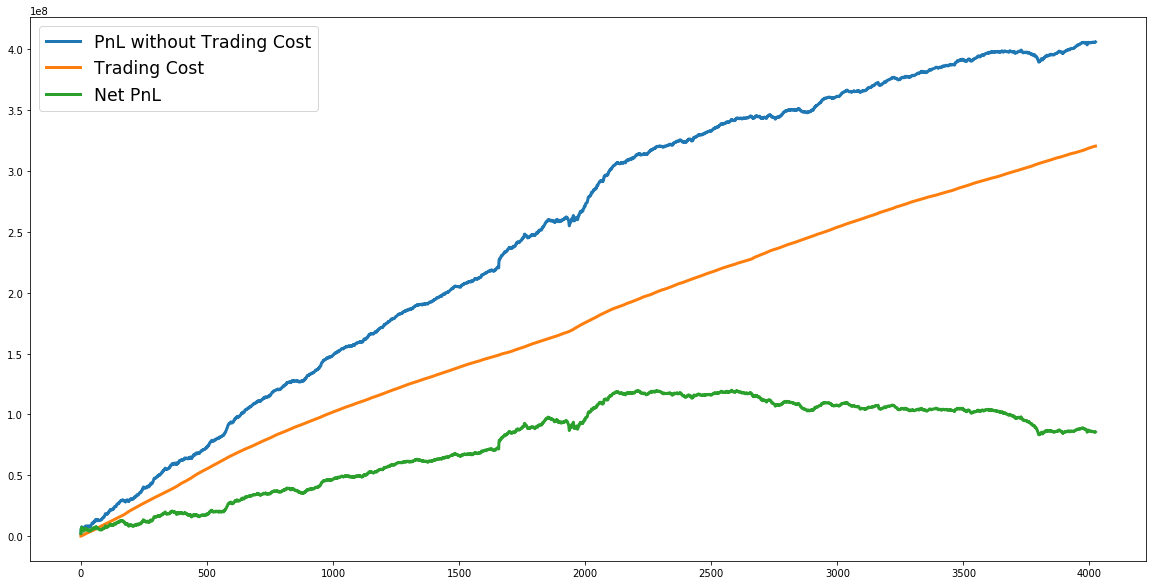

In [13]:
# Visualize PnL, Cost and NetPnL
fig = plt.figure(figsize = (20,10))
plt.plot(PnL,label = 'PnL without Trading Cost', linewidth = 3)
plt.plot(Cost, label = 'Trading Cost',linewidth = 3)
plt.plot(NetPnL, label = 'Net PnL', linewidth = 3)
plt.legend(loc='best',fontsize = 'xx-large')
plt.show()

Problem 3 - Black-Litterman Portfolio

In [14]:
# Parameters:

# Covariance Matrix of factors
F = np.cov(paralist_ols.T)

# cov martrix of prior is proportional on factor cov matrix
# tao is the proportion whose inverse represents the amount of precision in the prior
tao = 1

# omega is cov matrix of 'views' values
p = []
for df in dfs:
    df_ = df[df['ESTU']==1]
    alpha = df[['TD','TIR']].sum(axis = 1).values
    p.append(alpha.dot(df['R'].values))
omega = np.var(p)

In [15]:
def SIGMAinvPrd(X,F,D,Y):
    # This function is to calculate production of the inverse of a n*n matrix SIGMA and n*k matrix Y
    # SIGMA=D+XFX'. Here A=D(diag(n)), U=XF(n*k), V'=X'(k*n)
    # We use SWM formula to avoid using a n*n memory in the function
    # SIGMA^(-1)*Y = D^(-1)*Y-D^(-1)*(XF)*(I+X'*D^(-1)*(XF))^(-1)*X'*D^(-1)*Y
    k = len(F)
    invD = 1/D
    A1 = DiagProduct(invD,Y)
    A2 = DiagProduct(invD,X.dot(F))
    A3 = np.linalg.inv(np.eye(k)+X.T.dot(A2))
    A4 = X.T.dot(A1)
    return A1-A2.dot(A3).dot(A4)

In [16]:
# Store benckmark portfolio P/L in a list
PnL_eq = []

# Store Black-Litterman Portfolio P/L in another list
PnL_bl = []

for i in range(len(dfs)):
    # Only consider stocks in estimate universe (ESTU=1)   
    df = dfs[i][dfs[i]['ESTU']==1]
    
    # benchmark portfolio h_eq: capital weighted portfolio whose GMV = 500000000
    w = df['USDCAP'].values
    h_eq = 500000000/sum(abs(w))*w
    
    # cov matrix of return is SIGMA=XFX'+D is n*n but we don't actually store SIGMA here
    D = Sigma.loc[df.index,'Res%d'%i].values
    X = df[featurelist].values
    
    # P is composite alpha as arithmatic sum of TD and TIR which is n*1
    P = df[['TD','TIR']].sum(axis = 1).values
    
    # q is portfolio managers views, which should be given. Here we generate it as N(P*r,omega) which is a scaler here
    q = np.random.normal(P.dot(df['R'].values),np.sqrt(omega))
    
    # Black-Litterman has analytical optimization solution.
    # Again here we use SWM formula to avoid using a n*n memory
    # After calculation and simplification, we have following solution
    N = P.dot(X).dot(F).dot(X.T)+DiagProduct(D,P)
    k1 = omega**2*tao
    k2 = (omega**3)*(tao**2)/(1+omega*tao*N.dot(P))
    k3 = 1/(1+k1)
    k4 = k2*(k3**2)/(1+k2*k3*N.dot(P))
    M = P*q/omega+SIGMAinvPrd(X,F,D,h_eq)
    h = -k1*k3*M + (k4*k1+k2*k3)*P.dot(N.dot(M)) + (k4*k2)*N.dot(P)*N.dot(M)*P
   
    # Rescale h to GMV = 500000000
    h = 500000000/sum(abs(h))*h
    
    # Calculate P/L of benchmark portfolio and add into list
    PnL_eq.append(h_eq.dot(df['R'].values))
    
    # Calculate P/L of Black-Litterman portfolio and add into list
    PnL_bl.append(h.dot(df['R'].values))

# Calculate cumulative PnL
PnL_eq = np.cumsum(PnL_eq)
PnL_bl = np.cumsum(PnL_bl)

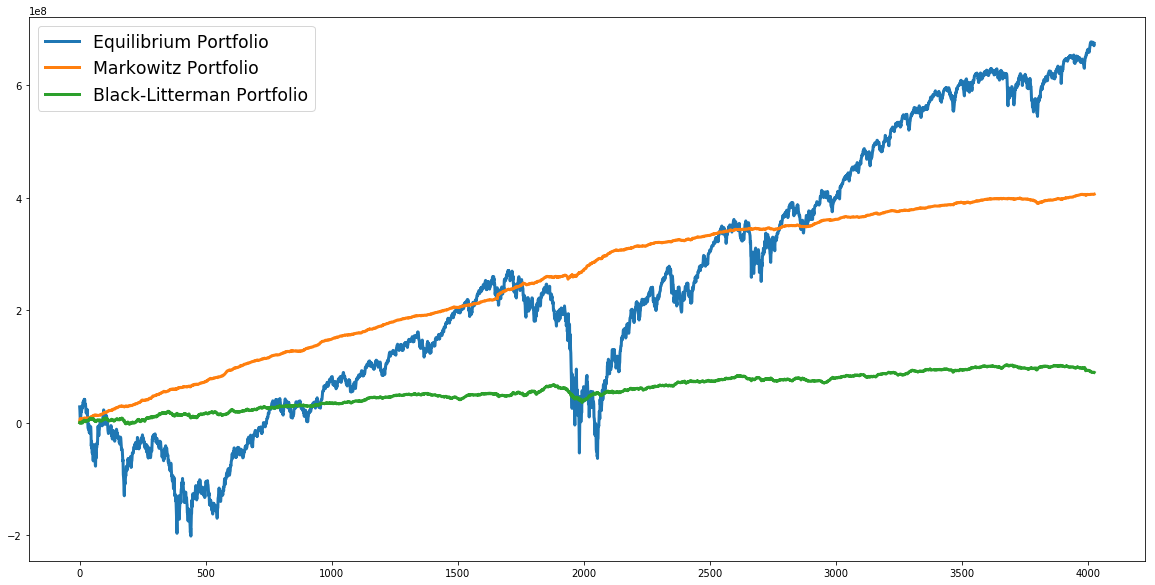

In [17]:
# Compare PnL of equilibrium portfolio(benchmark), Markowitz portfolio and Black-Litterman portfolio
fig = plt.figure(figsize = (20,10))
plt.plot(PnL_eq, label = 'Equilibrium Portfolio',linewidth = 3)
plt.plot(PnL, label = 'Markowitz Portfolio', linewidth = 3)
plt.plot(PnL_bl, label = 'Black-Litterman Portfolio', linewidth = 3)
plt.legend(loc='best',fontsize = 'xx-large')
plt.show()

Problem 4 - Linear Mixed-Effects Model

In [21]:
# In this problem, we use EM algorithm to solve LME model
# LME Model: r = X*beta + X*b + epsilon. b ~ N(0,THETA), epsilon ~ N(0, sigma^2*I)
# EM algorithm tells us: To solve a MLE where there is some data is not observeable, we follow 2 steps.
# E-step: Fixed parameter(beta, THETA, sigma^2 in LME), find expectation of latent variable(b in LME) conditional on
# observable data (r in LME)
# M-step: Fixed conditional expectation of latent variable, update parameter by maximizing likelihood function

def ParaUpdate(X, r, beta, THETA, sigmasq, n, k):
    
    # This function is one step update of parameter beta, THETA and sigma squared, given design matrix X and return r
    # X is n*k, r is n*1, beta is k*1, THETA is k*k, sigmasq is scaler
    # The function is devided to 2 parts: E-step and M-step
    
    # E-step begins:

    # By calculation we know conditional mean of b given parameter and return is
    # b = THETA*X'*(X*THETA*X'+sigma^2*I)^(-1)*(r-X*beta)
    # Again we use SWM formula to avoid using n*n memory, by using the already defined SIGMAinvProd function directly
    D = np.ones(n)*sigmasq
    Y = r - X.dot(beta)
    b = THETA.dot(X.T).dot(SIGMAinvPrd(X,THETA,D,Y))
    
    # Conditional covariance matrix of b given parameter and return is 
    # V = THETA - THETA*X'*(X*THETA*X'+sigma^2*I)^(-1)*X*THETA
    # Again we use SWM formula to avoid using n*n memory, by using the already defined SIGMAinvProd function directly
    Y = X.dot(THETA)
    V = THETA - THETA.dot(X.T).dot(SIGMAinvPrd(X,THETA,D,Y))
    
    # E-step finishes. 
    # M-step begins:
    
    # After maximum likelihood calculation we find 
    # beta updating is beta_new = (X'*X)^(-1)*X'*(r-X*b)
    beta_new = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(r-X.dot(b))
    
    # THETA updating is THETA_new = b*b' + V
    THETA_new = b.reshape(-1,1).dot(b.reshape(1,-1)) + V
    
    
    # sigma squared udating is sigma^2_new = A/n
    # where A = (r-X*beta)^2 + b'X'Xb + trace(VX'X) - 2b'X'(r-X*beta)
    A = sum((r-X.dot(beta))**2) + b.dot(X.T.dot(X.dot(b))) + np.trace(V.dot(X.T.dot(X))) - 2*b.dot(X.T.dot(r-X.dot(beta)))
    sigmasq_new = A/n
    
    # M-step finishes.
    
    # Calculate likelihood function
    # l = -n/2*log(sigma^2) - 1/2*log(|THETA|) - (r-X*b-X*beta)^2/(2*sigma^2) - b'*(THETA)^(-1)*b/2    
    #l1 = - n*np.log(2*np.pi*sigmasq)/2 - k*np.log(np.linalg.det(THETA))/2
    #l2 = - sum((r-X.dot(b)-X.dot(beta))**2)/(2*sigmasq) - b.dot(np.linalg.inv(THETA).dot(b))/2
    #l = l1 + l2
    
    return beta_new, THETA_new, sigmasq_new

In [22]:
def LMEoptimize(df):
    # This function receive one day dataframe, returns optimal parameter beta, THETA and sigmasq in LME Model using EM algorithm
    
    # Define design matrix, return and give n, k
    X = df[featurelist].values
    r = df['R'].values
    k = len(featurelist)
    n = len(X)
    
    # Initial values of parameters
    beta = np.zeros(k)
    THETA = np.eye(k)
    sigmasq = 0.01
    beta_new = np.ones(k)
    
    # running ED algorithm to find optimal parameters
    while min(abs(beta_new-beta)) > 0.001:
        beta = beta_new
        beta_new, THETA, sigmasq = ParaUpdate(X, r, beta, THETA, sigmasq, n, k)
    
    return beta_new, THETA, sigmasq

In [23]:
# Estimate LME model for each day
# Store factor return into a list
paralist_LME = []

# Store P/L in a list
PnL_LME = []

for df in dfs:
    # Only consider stocks in estimate universe (ESTU=1)
    df = df[df['ESTU']==1]
    
    # Solve optimal parameters assuming LME Model
    beta, THETA, sigmasq = LMEoptimize(df)
    
    # Append factor returns beta into list
    paralist_LME.append(beta)
    
    # Find Markowitz portfolio dollar weights h*=argmax(h'alpha-kappa*h'SIGMA*h/2) where SIGMA=X*THETA*X'+sigmasq*I
    # Calculate D,X,alpha,kappa, here alpha is X*beta while only alpha factors taken into consideration
    X = df[featurelist].values
    D = np.ones(len(X))*sigmasq
    alpha = X[:,4:6].dot(beta[4:6])
    kappa = 1
    
    # Markowitz optimazation
    h = MarkowitzOptimize(X,THETA,D,alpha,kappa)
    
    # choose kappa so that GMV(h)=500,000,000
    kappa = sum(abs(h))/500000000 
    # New h corresponding to new kappa
    h=h/kappa
        
    # Add daily P/L into list
    pnl = h.dot(df['R'].values)
    PnL_LME.append(pnl)
    
# Calculate mean factor return for all days
paralist_LME = np.array(paralist_LME)
f_LME = np.mean(paralist_LME,axis =0)

# Calculate cumulitive PnL
PnL_LME = np.cumsum(PnL_LME)

In [24]:
# featurelist = ['BETA','MOMENTUM','SIZE','VOL','TD','TIR']+list(classes)
# Print out average factors 'TD' and 'TIR'
toPrint = pd.DataFrame([f_OLS[4:6],f_WLS[4:6],f_LME[4:6]],index = ['OLS','WLS','LME'],columns=['TD','TIR'])
print(toPrint)

           TD       TIR
OLS  0.928771  1.498560
WLS  1.138372  1.316653
LME  0.928998  1.497150


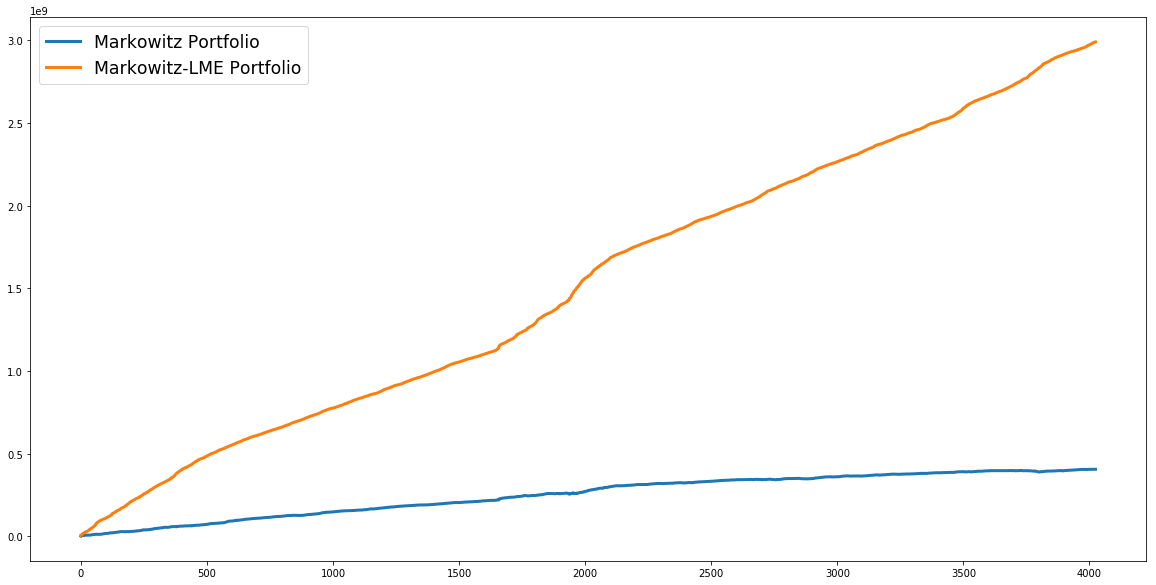

In [25]:
# Compare PnL of Markowitz portfolio and Markowitz-LME portfolio
fig = plt.figure(figsize = (20,10))
plt.plot(PnL, label = 'Markowitz Portfolio', linewidth = 3)
plt.plot(PnL_LME, label = 'Markowitz-LME Portfolio', linewidth = 3)
plt.legend(loc='best', fontsize = 'xx-large')
plt.show()